# Ablation Study 1: Model × Prompt (Extractor + Verifier)

## Objective
Find the best LLM + prompt combination for structured extraction using CSV-based extractor and verifier.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import io
import json
import os
from typing import List, Dict, Any
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

BASE_DIR = "/Users/guoshuyan/Desktop/OpenAD"
GOLD_DATA_CSV = os.path.join(BASE_DIR, "gold_annotation.csv")
UPSTREAM_KIMI_CSV = os.path.join(BASE_DIR, "Study2_outputs", "study2_upstream_kimi.csv")

EXTRACTOR_MODEL = 'Kimi-K2-Thinking'
VERIFIER_MODELS = ['Kimi-K2-Thinking', 'GPT-5-o', 'Gemini-2.5', 'Qwen-3-Max', 'DeepSeek-R1']
DEFAULT_VERIFIER_FOR_EXTRACTOR_SWEEP = 'Gemini-2.5'
EXTRACTOR_SWEEP_MODELS = ['Qwen-3-Max', 'GPT-5-o', 'Gemini-2.5', 'DeepSeek-R1']

SCHEMA_FIELDS = ['trial_id', 'source_sentence', 'criterion_type', 'ad_domain', 'clinical_concept',
                 'operator', 'value_lower', 'value_upper', 'units', 'diagnostic_framework',
                 'severity_stage', 'temporal_scope', 'evidence_type', 'certainty']


In [39]:
def load_gold_inputs() -> pd.DataFrame:
    """Join upstream Kimi segmentation with gold annotations."""
    upstream = pd.read_csv(UPSTREAM_KIMI_CSV)[['trial_id', 'criterion_type', 'source_sentence']]
    upstream = upstream.drop_duplicates()
    gold = pd.read_csv(GOLD_DATA_CSV)

    merged = upstream.merge(
        gold,
        on=['trial_id', 'criterion_type', 'source_sentence'],
        how='inner'
    )
    if merged.empty:
        raise ValueError("No overlapping rows between study2_upstream_kimi.csv and gold_annotation.csv.")
    return merged



In [ ]:
import os

# ---- Set them in the notebook environment ----
os.environ["OPENAI_API_KEY"]  = OPENAI_KEY
os.environ["GEMINI_API_KEY"]  = GEMINI_KEY
os.environ["DEEPSEEK_API_KEY"] = DEEPSEEK_KEY
os.environ["QWEN_API_KEY"]    = QWEN_KEY
os.environ["KIMI_API_KEY"]    = KIMI_KEY

# ---- Safe confirmation ----
print("API keys loaded into notebook environment:")
print(" OPENAI_API_KEY   =", "✔")
print(" GEMINI_API_KEY   =", "✔")
print(" DEEPSEEK_API_KEY =", "✔")
print(" QWEN_API_KEY     =", "✔")
print(" KIMI_API_KEY     =", "✔")


API keys loaded into notebook environment:
 OPENAI_API_KEY   = ✔
 GEMINI_API_KEY   = ✔
 DEEPSEEK_API_KEY = ✔
 QWEN_API_KEY     = ✔
 KIMI_API_KEY     = ✔


## Extractor Prompt (CSV-based)


In [41]:
def create_extractor_prompt(trial_id: str, criterion_type: str, source_sentence: str) -> str:
    """Create JSON-based extractor prompt leveraging upstream Kimi segmentation."""
    prompt = f"""You are an expert in Alzheimer's disease (AD) clinical trial eligibility extraction.

You will be given the trial_id, criterion_type, and a single sentence that already passed the upstream segmentation pipeline (study2_upstream_kimi.csv). Your job is to populate the full OpenAD schema for that sentence.

---------------------------
RESPONSE FORMAT (JSON)
---------------------------
Return EXACTLY one JSON object with these keys (strings only):
{{
  "trial_id": "...",
  "source_sentence": "...",
  "criterion_type": "...",
  "ad_domain": "...",
  "clinical_concept": "...",
  "operator": "...",
  "value_lower": "...",
  "value_upper": "...",
  "units": "...",
  "diagnostic_framework": "...",
  "severity_stage": "...",
  "temporal_scope": "...",
  "evidence_type": "...",
  "certainty": "..."
}}

Allowed ad_domain values: cognitive, biomarker, imaging, labs, comorbidity, functional, demographic, safety, treatment-history, AD-diagnostics.

Rules:
- Copy trial_id, criterion_type, and source_sentence EXACTLY as provided.
- Fill the other fields ONLY if explicitly supported by the sentence; otherwise use an empty string "".
- Use operators such as ≥, ≤, >, <, =, between, present, absent, history-of, confirmed, etc.
- Use numeric strings for values (e.g., "20").
- Output must be pure JSON (no Markdown code fences, no commentary).

---------------------------
INPUT
---------------------------
TRIAL_ID: {trial_id}
CRITERION_TYPE: {criterion_type}
SOURCE_SENTENCE: {source_sentence}

---------------------------
OUTPUT
---------------------------
Return ONLY the JSON object described above.
"""
    return prompt

## Verifier Prompt (CSV-based)


In [42]:
def create_verifier_prompt(source_sentence: str, extracted_csv_row: str) -> str:
    """Create CSV-based verifier prompt."""
    prompt = f"""You are verifying the correctness of a structured extraction of an AD clinical trial eligibility criterion.

You will be given:
1) The original source sentence.
2) A CSV row produced by another model with the following columns in order:

trial_id,source_sentence,criterion_type,ad_domain,clinical_concept,operator,value_lower,value_upper,units,diagnostic_framework,severity_stage,temporal_scope,evidence_type,certainty

---------------------------
YOUR TASK
---------------------------
For EACH field in this schema, you must decide:

- present_in_text: true if the information for this field is explicitly expressed in the source sentence; false otherwise.
- is_correct: true if the value in the CSV row correctly reflects the meaning of the sentence; false otherwise.
- correct_value:
    - If present_in_text = true and the CSV value is wrong or empty, supply the correct value.
    - If present_in_text = true and the CSV value is correct, repeat that value.
    - If present_in_text = false, leave correct_value empty.

You MUST output a CSV table with:
- ONE header row
- ONE row per field

The columns MUST be in this exact order:

field,present_in_text,is_correct,correct_value

You MUST create a row for EACH of these fields (in this order):
trial_id
source_sentence
criterion_type
ad_domain
clinical_concept
operator
value_lower
value_upper
units
diagnostic_framework
severity_stage
temporal_scope
evidence_type
certainty

---------------------------
RULES
---------------------------
- Do NOT infer information that is not clearly present in the sentence.
- "present_in_text" = true only if the sentence actually states or implies the field explicitly.
- "is_correct" = true only if the CSV value matches the sentence's meaning.
- For source_sentence:
    - present_in_text must always be true.
    - is_correct is true only if the CSV sentence exactly matches the original.
- Use lowercase true/false (without quotes) for Boolean values.
- If correct_value contains commas, wrap it in double quotes.
- Do NOT output any explanation, ONLY the CSV.

---------------------------
INPUT
---------------------------
ORIGINAL SENTENCE:
{source_sentence}

EXTRACTED CSV ROW:
{extracted_csv_row}

---------------------------
OUTPUT
---------------------------
Return ONLY the CSV table:

field,present_in_text,is_correct,correct_value
<one row per field in the order specified above>
"""
    return prompt


LLM wrapper

In [43]:
from openai import OpenAI


def call_kimi(prompt: str) -> str:
    api_key = os.getenv("KIMI_API_KEY") or os.getenv("MOONSHOT_API_KEY")
    if not api_key:
        raise RuntimeError("KIMI_API_KEY or MOONSHOT_API_KEY not set.")

    client = OpenAI(api_key=api_key, base_url="https://api.moonshot.ai/v1")
    completion = client.chat.completions.create(
        model="kimi-k2-turbo-preview",
        messages=[
            {"role": "system", "content": "You are Kimi, an expert clinical trial information extraction and verification assistant."},
            {"role": "user", "content": prompt},
        ],
        temperature=0.0,
    )
    return completion.choices[0].message.content.strip()


def call_gpt5o(prompt: str) -> str:
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY not set.")

    client = OpenAI(api_key=api_key)
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
    )
    return completion.choices[0].message.content.strip()


def call_gemini(prompt: str) -> str:
    import google.generativeai as genai

    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise RuntimeError("GEMINI_API_KEY not set.")

    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-2.5-pro")
    resp = model.generate_content(prompt)
    return resp.text.strip()


def call_qwen(prompt: str) -> str:
    api_key = os.getenv("DASHSCOPE_API_KEY") or os.getenv("QWEN_API_KEY")
    if not api_key:
        raise RuntimeError("QWEN_API_KEY not set.")

    client = OpenAI(api_key=api_key, base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1")
    completion = client.chat.completions.create(
        model="qwen-plus",
        messages=[{"role": "system", "content": "You are a precise verifier of clinical trial schema."}, {"role": "user", "content": prompt}],
        temperature=0.0,
    )
    return completion.choices[0].message.content.strip()


def call_deepseek(prompt: str) -> str:
    api_key = os.getenv("DEEPSEEK_API_KEY")
    if not api_key:
        raise RuntimeError("DEEPSEEK_API_KEY not set.")

    client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
    completion = client.chat.completions.create(
        model="deepseek-reasoner",
        messages=[{"role": "system", "content": "You are a precise verifier of AD eligibility schema."}, {"role": "user", "content": prompt}],
        temperature=0.0,
    )
    return completion.choices[0].message.content.strip()


def call_verifier_model(model_name: str, prompt: str) -> str:
    if model_name == 'Kimi-K2-Thinking':
        return call_kimi(prompt)
    if model_name == 'GPT-5-o':
        return call_gpt5o(prompt)
    if model_name == 'Gemini-2.5':
        return call_gemini(prompt)
    if model_name == 'Qwen-3-Max':
        return call_qwen(prompt)
    if model_name == 'DeepSeek-R1':
        return call_deepseek(prompt)
    raise ValueError(f"Unknown verifier model: {model_name}")



In [44]:
def call_llm_extractor(prompt: str, defaults: Dict[str, str]) -> Dict[str, Any]:
    """Call the production extractor (Kimi) and parse its JSON output."""
    response_text = call_kimi(prompt)
    return parse_json_extraction(response_text, defaults)

def call_llm_verifier(model_name: str, prompt: str) -> pd.DataFrame:
    """Call the specified verifier model and parse CSV output."""
    response_text = call_verifier_model(model_name, prompt)
    return parse_verification_csv(response_text)

def parse_json_extraction(response_text: str, defaults: Dict[str, str]) -> Dict[str, Any]:
    """Parse JSON extractor response and normalize to schema."""
    text = response_text.strip()
    start = text.find('{')
    end = text.rfind('}')
    if start == -1 or end == -1 or end <= start:
        raise ValueError("Extractor response did not contain a JSON object.")
    payload = text[start : end + 1]
    data = json.loads(payload)
    if isinstance(data, list):
        data = data[0] if data else {}

    normalized = {}
    for field in SCHEMA_FIELDS:
        value = data.get(field, "") if isinstance(data, dict) else ""
        if value is None:
            value = ""
        normalized[field] = str(value).strip()

    for key, val in defaults.items():
        if not normalized.get(key):
            normalized[key] = val
    return normalized

def dict_to_csv_row(record: Dict[str, Any]) -> str:
    """Convert a schema dict into a single CSV row string."""
    buffer = io.StringIO()
    writer = csv.DictWriter(buffer, fieldnames=SCHEMA_FIELDS)
    writer.writeheader()
    writer.writerow({field: record.get(field, "") for field in SCHEMA_FIELDS})
    return buffer.getvalue().strip().split('\n')[1]

def parse_verification_csv(csv_text: str) -> pd.DataFrame:
    """Parse verification CSV response with fallback handling."""
    lines = [line for line in csv_text.strip().split('\n') if line.strip()]
    if not lines:
        return pd.DataFrame(columns=['field', 'present_in_text', 'is_correct', 'correct_value'])

    reader = csv.reader(lines)
    header = next(reader)
    expected_header = ['field', 'present_in_text', 'is_correct', 'correct_value']
    rows = []
    for row in reader:
        if not row:
            continue
        if len(row) < 4:
            row = row + [''] * (4 - len(row))
        elif len(row) > 4:
            row = row[:3] + [','.join(row[3:])]
        rows.append(dict(zip(expected_header, row)))

    df = pd.DataFrame(rows, columns=expected_header)
    for col in ['present_in_text', 'is_correct']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.lower().map({'true': True, 'false': False})
    df['correct_value'] = df['correct_value'].fillna('').astype(str).str.strip()
    return df


## Evaluation Metrics


In [45]:
def calculate_extractor_completeness(extracted: Dict[str, Any], gold: pd.Series) -> float:
    """Calculate extractor field completeness."""
    gold_non_empty = gold.notna().sum()
    if gold_non_empty == 0:
        return 1.0
    
    extracted_non_empty = sum(1 for field in SCHEMA_FIELDS 
                             if field in extracted and extracted[field] not in [None, '', np.nan])
    
    return extracted_non_empty / gold_non_empty if gold_non_empty > 0 else 0.0

def calculate_extractor_correctness(extracted: Dict[str, Any], gold: pd.Series) -> float:
    """Calculate extractor field correctness."""
    gold_non_empty = gold[gold.notna()]
    if len(gold_non_empty) == 0:
        return 1.0
    
    correct = 0
    for field in gold_non_empty.index:
        if field in extracted:
            extracted_val = str(extracted[field]).strip().lower()
            gold_val = str(gold[field]).strip().lower()
            if extracted_val == gold_val:
                correct += 1
    
    return correct / len(gold_non_empty) if len(gold_non_empty) > 0 else 0.0

def calculate_verifier_vacancy_accuracy(verification_df: pd.DataFrame, gold: pd.Series) -> float:
    """Calculate verifier vacancy detection accuracy."""
    if len(verification_df) == 0:
        return 0.0
    
    correct_flags = 0
    total_fields = len(SCHEMA_FIELDS)
    
    for field in SCHEMA_FIELDS:
        field_row = verification_df[verification_df['field'] == field]
        if len(field_row) > 0:
            present_in_text = field_row.iloc[0]['present_in_text']
            gold_present = pd.notna(gold.get(field, np.nan)) and str(gold.get(field, '')).strip() != ''
            
            if (present_in_text == True and gold_present) or (present_in_text == False and not gold_present):
                correct_flags += 1
    
    return correct_flags / total_fields if total_fields > 0 else 0.0

def calculate_verifier_correction_accuracy(verification_df: pd.DataFrame, gold: pd.Series) -> float:
    """Calculate verifier correction accuracy."""
    corrections = verification_df[
        (verification_df['is_correct'] == False) & 
        (verification_df['correct_value'].notna()) &
        (verification_df['correct_value'] != '')
    ]
    
    if len(corrections) == 0:
        return 1.0
    
    correct_corrections = 0
    for _, row in corrections.iterrows():
        field = row['field']
        correct_value = str(row['correct_value']).strip().lower()
        gold_value = str(gold.get(field, '')).strip().lower()
        if correct_value == gold_value:
            correct_corrections += 1
    
    return correct_corrections / len(corrections) if len(corrections) > 0 else 0.0

def apply_verifier_corrections(extracted: Dict[str, Any], verification_df: pd.DataFrame) -> Dict[str, Any]:
    """Apply verifier corrections to extracted data."""
    corrected = extracted.copy()
    
    for _, row in verification_df.iterrows():
        field = row['field']
        is_correct = row['is_correct']
        correct_value = row.get('correct_value', '')
        
        if is_correct == False and pd.notna(correct_value) and correct_value != '':
            corrected[field] = correct_value
    
    return corrected


## Main Evaluation Pipeline


In [46]:
def evaluate_extractor_verifier_pair(extractor_model: str, verifier_model: str,
                                     trial_id: str, criterion_type: str,
                                     source_sentence: str, gold_row: pd.Series) -> Dict[str, Any]:
    """Evaluate extractor + verifier pair."""
    extractor_prompt = create_extractor_prompt(trial_id, criterion_type, source_sentence)
    defaults = {
        'trial_id': trial_id,
        'criterion_type': criterion_type,
        'source_sentence': source_sentence,
    }
    extracted = call_llm_extractor(extractor_prompt, defaults)

    extracted_csv = dict_to_csv_row(extracted)

    verifier_prompt = create_verifier_prompt(source_sentence, extracted_csv)
    verification_df = call_llm_verifier(verifier_model, verifier_prompt)

    corrected = apply_verifier_corrections(extracted, verification_df)

    extractor_completeness = calculate_extractor_completeness(extracted, gold_row)
    extractor_correctness = calculate_extractor_correctness(extracted, gold_row)
    verifier_vacancy = calculate_verifier_vacancy_accuracy(verification_df, gold_row)
    verifier_correction = calculate_verifier_correction_accuracy(verification_df, gold_row)
    corrected_correctness = calculate_extractor_correctness(corrected, gold_row)

    return {
        'extractor_model': extractor_model,
        'verifier_model': verifier_model,
        'trial_id': trial_id,
        'extractor_completeness': extractor_completeness,
        'extractor_correctness': extractor_correctness,
        'verifier_vacancy_accuracy': verifier_vacancy,
        'verifier_correction_accuracy': verifier_correction,
        'end_to_end_accuracy': corrected_correctness
    }


def run_ablation1_evaluation(sample_size: int | None = None) -> pd.DataFrame:
    """Run Ablation Study 1 with fixed Kimi extractor and various verifiers."""
    dataset = load_gold_inputs()
    if sample_size is not None:
        dataset = dataset.head(sample_size)

    all_results: List[Dict[str, Any]] = []

    for verifier_model in VERIFIER_MODELS:
        print(f"Evaluating Kimi extractor + {verifier_model} verifier...")
        for _, gold_row in dataset.iterrows():
            result = evaluate_extractor_verifier_pair(
                EXTRACTOR_MODEL,
                verifier_model,
                gold_row['trial_id'],
                gold_row['criterion_type'],
                gold_row['source_sentence'],
                gold_row
            )
            all_results.append(result)

    return pd.DataFrame(all_results)


In [47]:
def run_extractor_sweep(
    verifier_model: str,
    extractor_models: List[str],
    sample_size: int | None = None
) -> pd.DataFrame:
    """Evaluate multiple extractor models against a fixed verifier."""
    dataset = load_gold_inputs()
    if sample_size is not None:
        dataset = dataset.head(sample_size)

    all_results: List[Dict[str, Any]] = []

    for extractor_model in extractor_models:
        print(f"Evaluating {extractor_model} extractor + {verifier_model} verifier...")
        for _, gold_row in dataset.iterrows():
            result = evaluate_extractor_verifier_pair(
                extractor_model,
                verifier_model,
                gold_row['trial_id'],
                gold_row['criterion_type'],
                gold_row['source_sentence'],
                gold_row
            )
            all_results.append(result)

    return pd.DataFrame(all_results)


In [48]:
def plot_end_to_end(summary_df: pd.DataFrame) -> None:
    if summary_df.empty:
        print("No data available for plotting.")
        return

    accuracies = summary_df['end_to_end_accuracy']
    bins = max(len(accuracies), 3)
    bin_edges = np.linspace(accuracies.min() - 0.01, accuracies.max() + 0.01, bins + 1)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.hist(accuracies, bins=bin_edges, color='#354898', edgecolor='white', alpha=0.85)
    ax.set_xlabel('End-to-end accuracy')
    ax.set_ylabel('Verifier count')
    ax.set_xlim(0, 1)
    ax.set_title('Verifier impact on end-to-end accuracy (Kimi extractor)')

    ymax = ax.get_ylim()[1]
    for accuracy, model in zip(accuracies, summary_df['verifier_model']):
        ax.axvline(accuracy, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.text(accuracy, ymax * 0.95, model, rotation=90, ha='center', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()


Evaluating Kimi extractor + Kimi-K2-Thinking verifier...
Evaluating Kimi extractor + GPT-5-o verifier...
Evaluating Kimi extractor + Gemini-2.5 verifier...
Evaluating Kimi extractor + Qwen-3-Max verifier...
Evaluating Kimi extractor + DeepSeek-R1 verifier...
Ablation Study 1 – Summary (Kimi extractor + verifier sweep):


,verifier_model,extractor_completeness,extractor_correctness,verifier_vacancy_accuracy,verifier_correction_accuracy,end_to_end_accuracy
2,Gemini-2.5,0.647787,0.356142,0.555195,0.670455,0.362065
0,DeepSeek-R1,0.653228,0.357404,0.495671,0.818182,0.359132
1,GPT-5-o,0.649050,0.357152,0.569264,0.914141,0.357152
3,Kimi-K2-Thinking,0.651575,0.357152,0.542208,0.946970,0.355637
4,Qwen-3-Max,0.651828,0.356239,0.594156,0.689394,0.353943


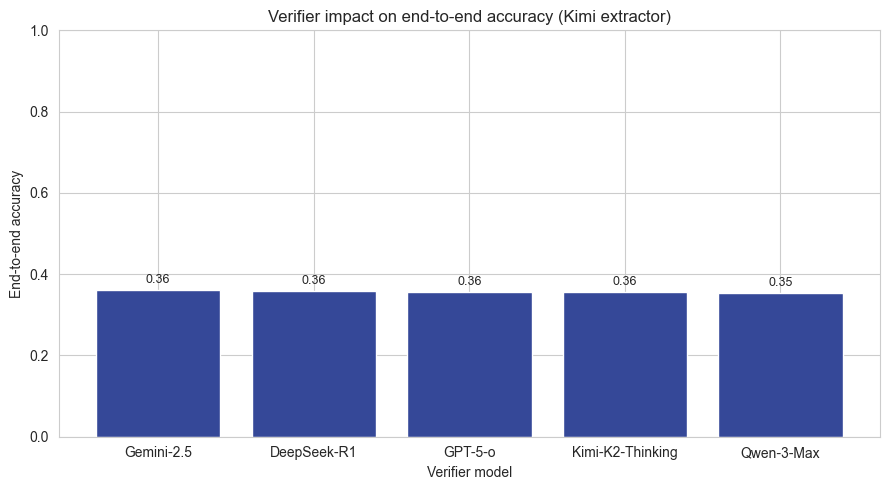

In [23]:
# ---- Run Ablation Study 1 ----
results_df = run_ablation1_evaluation()
summary_df = summarize_results(results_df)

print("Ablation Study 1 – Summary (Kimi extractor + verifier sweep):")
display(summary_df)

plot_end_to_end(summary_df)

## Run Evaluation


In [24]:
results_df = run_ablation1_evaluation()
results_df.to_csv('ablation1_results.csv', index=False)
print("Evaluation complete. Results saved to ablation1_results.csv")
print(f"\nResults summary:")
print(results_df.groupby(['extractor_model', 'verifier_model']).agg({
    'extractor_completeness': 'mean',
    'extractor_correctness': 'mean',
    'end_to_end_accuracy': 'mean'
}).round(3))


Evaluating Kimi extractor + Kimi-K2-Thinking verifier...
Evaluating Kimi extractor + GPT-5-o verifier...
Evaluating Kimi extractor + Gemini-2.5 verifier...
Evaluating Kimi extractor + Qwen-3-Max verifier...
Evaluating Kimi extractor + DeepSeek-R1 verifier...
Evaluation complete. Results saved to ablation1_results.csv

Results summary:
                                   extractor_completeness  \
extractor_model  verifier_model                             
Kimi-K2-Thinking DeepSeek-R1                        0.653   
                 GPT-5-o                            0.652   
                 Gemini-2.5                         0.646   
                 Kimi-K2-Thinking                   0.648   
                 Qwen-3-Max                         0.649   

                                   extractor_correctness  end_to_end_accuracy  
extractor_model  verifier_model                                                
Kimi-K2-Thinking DeepSeek-R1                       0.356                0.3